# Global importance analysis of motif number and identity
Visualize the results of global importance analysis and compare the results to experimental data.

Required inputs:
* `synthetic_insertion_preds.txt`: the predicted activity of each background sequence on its own and with various combinations of motifs inserted at fixed positions. Bonus second file which contains a second set of positions, but these are not used in the manuscript.
* `activity_summary_stats_and_metadata.txt`
* `eLifeMotifs.meme`: the 8 PWMs used in the Friedman et al., eLife, 2021 study.

Outputs:
* `motifNumberImportance_{tf names}_{FirstSet,SecondSet}.svg`: violin plots of the predicted importance of various numbers and combinations of motifs.
* `gcVs4Crx.svg`: scatterplot of the predicted effect of four consensus CRX motifs vs. the GC content of the background sequence.
* `gcVs4Background.svg`: scatterplot of the predicted *activity* of each background sequence vs. its GC content.
* `genomicMotifCountVsActivity.svg`: violin plot of the activity of genomic sequences from the eLife study containing exactly 1 CRX motif, and either NRL or RORB motifs, and no detectable instances of the other 5 motifs.
* `strongEnhancerMutate{NRL,NDF1,RORB,MAZ,MEF2D}.svg`: violin plots of the observed effects of scrambling all instances of a TF motif in all genomic strong enhancers, stratified by the number of motifs scrambled. Bonus figures not used in the manuscript are generated.

In [1]:
import os
import sys
import itertools
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import selene_sdk
from deeplift.dinuc_shuffle import dinuc_shuffle

from src.mpra_tools import fasta_utils, loaders, modeling, predicted_occupancy, plot_utils

from IPython.display import display

figures_dir = "Figures"
plot_utils.set_manuscript_params()

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper functions.

In [2]:
tf_names = [
    "CRX",
    "GFI1",
    "MAZ",
    "MEF2D",
    "NDF1",
    "NRL",
    "RAX",
    "RORB",
]

# Read in big table and separate out info about sequence used
def load_table(f):
    importance_df = loaders.load_data(f)
    shuffle_seq = importance_df["shuffle_seq"]
    gc_content = importance_df["gc_content"]
    importance_df = importance_df.drop(columns=["shuffle_seq", "gc_content"])
    return importance_df, shuffle_seq, gc_content

# Generate lookup table to decode columns
# Info about number of sites for each TF and the total number
def get_decoder(df):
    column_str_method = df.columns.str
    column_lookup = {
        tf: column_str_method.count(tf)
        for tf in tf_names
    }
    column_lookup["Total"] = column_str_method.split(",").str.len()
    column_lookup = pd.DataFrame(column_lookup, index=df.columns)
    # Need to manually adjust background because of how things were encoded
    column_lookup.loc["background", "Total"] = 0
    display(column_lookup.head())
    return column_lookup
        
# Massage importance scores for plotting
def df_to_groupby(df):
    return df.melt(ignore_index=False).groupby("variable")

# Plot horizontal lines for the class cutoffs
def plot_cutoffs(ax):
    for y in [-1, 1, loaders.get_strong_cutoff()]:
        ax.axhline(y, color="k", linestyle="--")

FirstSet


,CRX,GFI1,MAZ,MEF2D,NDF1,NRL,RAX,RORB,Total
background,0,0,0,0,0,0,0,0,0
78CRX,1,0,0,0,0,0,0,0,1
78GFI1,0,1,0,0,0,0,0,0,1
78MAZ,0,0,1,0,0,0,0,0,1
78MEF2D,0,0,0,1,0,0,0,0,1


,count,mean,std,min,25%,50%,75%,max
CRX,,,,,,,,
1,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
2,4658.0,-0.208322,1.124652,-5.804861,-0.798281,0.069027,0.592656,1.974420
3,4658.0,-1.434001,1.496490,-6.088587,-2.543371,-1.349148,-0.208560,1.977373
4,4658.0,-3.044249,1.626326,-8.019793,-4.201240,-3.228801,-1.988557,1.799853


,count,mean,std,min,25%,50%,75%,max
GFI1,,,,,,,,
0,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
1,4658.0,-0.448413,0.789452,-4.436013,-0.862620,-0.304323,0.078937,1.811610
2,4658.0,-0.966736,0.947220,-4.978939,-1.567055,-0.810591,-0.251955,1.912683
3,4658.0,-2.040137,1.190461,-5.739144,-2.908705,-2.066714,-1.098178,1.201456


,count,mean,std,min,25%,50%,75%,max
MAZ,,,,,,,,
0,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
1,4658.0,0.499018,0.460777,-3.240579,0.246939,0.507932,0.773211,3.461504
2,4658.0,0.818029,0.484949,-2.981264,0.518547,0.810691,1.103139,4.844643
3,4658.0,1.110816,0.581471,-1.524321,0.741227,1.080237,1.440365,5.144573


,count,mean,std,min,25%,50%,75%,max
MEF2D,,,,,,,,
0,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
1,4658.0,2.018790,0.553686,-0.080477,1.675389,1.973363,2.302462,5.405062
2,4658.0,2.434996,0.590427,0.419390,2.076718,2.371635,2.721742,6.021996
3,4658.0,2.826401,0.661076,0.190686,2.429323,2.779170,3.162176,7.178720


,count,mean,std,min,25%,50%,75%,max
NDF1,,,,,,,,
0,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
1,4658.0,1.979474,0.537572,-0.441665,1.646666,1.945188,2.268464,5.737795
2,4658.0,2.849928,0.558768,0.646034,2.510990,2.795093,3.123492,6.549493
3,4658.0,3.585999,0.644011,1.267097,3.198104,3.532047,3.907715,7.933961


,count,mean,std,min,25%,50%,75%,max
NRL,,,,,,,,
0,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
1,4658.0,0.664683,0.560084,-2.776890,0.326125,0.642854,0.999991,3.960179
2,4658.0,1.009429,0.586827,-1.314404,0.612608,0.982935,1.361445,4.984556
3,4658.0,1.248660,0.681382,-1.807030,0.793782,1.201282,1.655485,5.144617


,count,mean,std,min,25%,50%,75%,max
RAX,,,,,,,,
0,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
1,4658.0,-0.120349,0.759243,-5.204045,-0.452330,0.004058,0.365533,2.339230
2,4658.0,-0.419791,0.984806,-5.672967,-0.876819,-0.211097,0.247266,2.126639
3,4658.0,-0.813373,1.277614,-6.808348,-1.560533,-0.569166,0.123526,2.324772


,count,mean,std,min,25%,50%,75%,max
RORB,,,,,,,,
0,4658.0,0.050104,0.499158,-3.850349,-0.144201,0.115496,0.344278,1.394455
1,4658.0,2.029244,0.567475,-0.572610,1.672828,1.999632,2.338002,5.113195
2,4658.0,2.729393,0.582819,0.555654,2.381934,2.671371,3.011672,6.209044
3,4658.0,3.417220,0.660529,1.130278,3.018456,3.359386,3.751224,7.556034


GC content vs background, PCC=-0.06869901926676694, SCC=-0.059727531333224296
GC content vs 4 CRX, PCC=0.386812480704692, SCC=0.3893872742224788
SecondSet


,CRX,GFI1,MAZ,MEF2D,NDF1,NRL,RAX,RORB,Total
background,0,0,0,0,0,0,0,0,0
8CRX,1,0,0,0,0,0,0,0,1
8GFI1,0,1,0,0,0,0,0,0,1
8MAZ,0,0,1,0,0,0,0,0,1
8MEF2D,0,0,0,1,0,0,0,0,1


,count,mean,std,min,25%,50%,75%,max
CRX,,,,,,,,
1,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
2,4658.0,-0.295582,0.563059,-3.135163,-0.569249,-0.167491,0.090610,0.881625
3,4658.0,-0.915155,0.978372,-5.068869,-1.553365,-0.725037,-0.155587,1.150635
4,4658.0,-2.040546,1.305140,-6.663643,-2.978570,-2.054489,-1.065703,1.153018


,count,mean,std,min,25%,50%,75%,max
GFI1,,,,,,,,
0,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
1,4658.0,-0.284257,0.390335,-2.698802,-0.464102,-0.209581,-0.024696,0.756498
2,4658.0,-0.652637,0.566126,-3.620717,-0.962534,-0.539808,-0.249619,0.782057
3,4658.0,-1.149940,0.779244,-4.409870,-1.652934,-1.041852,-0.552675,1.100388


,count,mean,std,min,25%,50%,75%,max
MAZ,,,,,,,,
0,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
1,4658.0,0.061109,0.282467,-1.853548,-0.066892,0.093237,0.235977,1.591797
2,4658.0,0.137096,0.346910,-2.322413,-0.036393,0.149899,0.336238,2.604868
3,4658.0,0.258756,0.420007,-2.393307,0.036864,0.260751,0.486143,4.873757


,count,mean,std,min,25%,50%,75%,max
MEF2D,,,,,,,,
0,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
1,4658.0,0.795877,0.308282,-0.259629,0.603504,0.763661,0.941616,3.520681
2,4658.0,1.339114,0.438202,0.194814,1.066267,1.288912,1.535980,4.959993
3,4658.0,1.812385,0.529232,0.148791,1.492332,1.749480,2.051741,5.893807


,count,mean,std,min,25%,50%,75%,max
NDF1,,,,,,,,
0,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
1,4658.0,0.914523,0.330026,-0.481976,0.707711,0.891989,1.083169,3.251146
2,4658.0,1.811537,0.435952,0.557352,1.542074,1.765782,2.013032,5.653941
3,4658.0,2.659220,0.503029,1.098825,2.347876,2.594251,2.883307,6.643962


,count,mean,std,min,25%,50%,75%,max
NRL,,,,,,,,
0,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
1,4658.0,0.271555,0.271438,-1.479499,0.123217,0.261385,0.410480,2.084931
2,4658.0,0.525107,0.362263,-1.694755,0.307272,0.484177,0.694782,4.369912
3,4658.0,0.779984,0.466144,-0.937554,0.478473,0.717763,1.006934,5.172363


,count,mean,std,min,25%,50%,75%,max
RAX,,,,,,,,
0,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
1,4658.0,-0.128502,0.385818,-2.612658,-0.278790,-0.056230,0.118482,0.833894
2,4658.0,-0.226041,0.547351,-3.519385,-0.443125,-0.104859,0.126522,1.256022
3,4658.0,-0.335551,0.710759,-4.987639,-0.613885,-0.165536,0.120614,1.627009


,count,mean,std,min,25%,50%,75%,max
RORB,,,,,,,,
0,4658.0,-0.033875,0.230860,-1.397660,-0.124840,0.008965,0.109140,0.655076
1,4658.0,0.870586,0.326629,-0.143496,0.663662,0.836172,1.029650,3.653948
2,4658.0,1.691404,0.454598,0.272824,1.404427,1.642585,1.888201,5.499154
3,4658.0,2.466034,0.529932,0.802726,2.131202,2.409489,2.710579,6.436456


GC content vs background, PCC=-0.06869901926676694, SCC=-0.059727531333224296
GC content vs 4 CRX, PCC=0.3260509262399264, SCC=0.3199808824828702


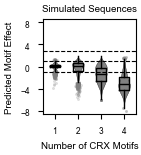

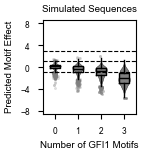

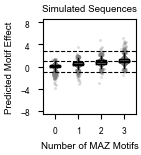

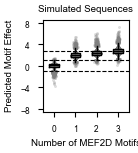

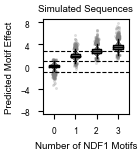

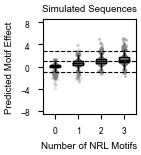

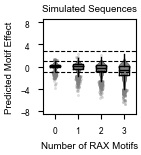

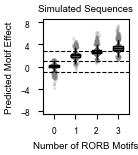

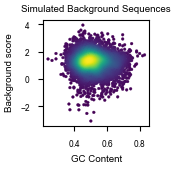

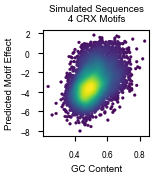

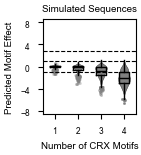

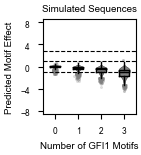

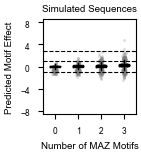

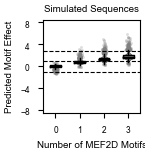

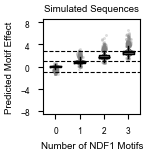

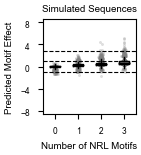

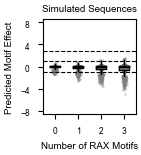

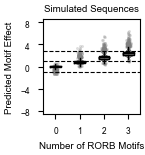

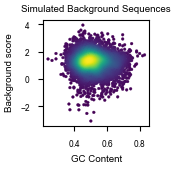

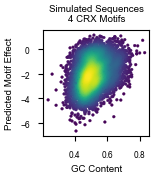

In [3]:
position_sets = [("FirstSet", "78CRX"), ("SecondSet", "^8CRX")]
# ymin = 100
# ymax = -100
ylim = [-8.562703622111469, 8.52317672]

for (i, crx_position) in position_sets:
    print(i)
    importance_df, shuffle_seq, gc_content = load_table(os.path.join("ImportanceAnalysis", "MotifCombos", i, "synthetic_insertion_preds.txt"))
    background = importance_df["background"]
    column_lookup = get_decoder(importance_df)
    
    # Plot effect of each TF
    for tf in tf_names:
        if tf == "CRX":
            column_mask = column_lookup.index.str.contains(crx_position) & (column_lookup["CRX"] == column_lookup["Total"])
        else:
            column_mask = column_lookup.index.str.contains(crx_position) &\
                (
                    (column_lookup["CRX"] == 1) &
                    (column_lookup[["CRX", tf]].sum(axis=1) == column_lookup["Total"])
                )
        crx_add_tf = importance_df.loc[:, column_mask]
        crx_add_tf_vs_bkgd = crx_add_tf.subtract(background, axis="index")
        # Count number of sites for TF2
        crx_add_tf_vs_bkgd = crx_add_tf_vs_bkgd.rename(columns=lambda x: len(re.findall(tf, x)))
        grouper = df_to_groupby(crx_add_tf_vs_bkgd)
        display(grouper["value"].describe().rename_axis(index=tf))

        fig = plot_utils.violin_plot_groupby(
            grouper["value"],
            None,
            figax=plt.subplots(figsize=plot_utils.get_figsize(0.2, 1))
        )
        ax = fig.axes[0]
        ax.set_yticks(np.arange(-8, 9, 4))
        ax.set_xlabel(f"Number of {tf} Motifs")
        ax.set_ylabel("Predicted Motif Effect")
        ax.set_title("Simulated Sequences")
        plot_cutoffs(ax)
        ax.set_ylim(ylim)
        
        # limits = ax.get_ylim()
        # ymin = min(ymin, limits[0])
        # ymax = max(ymax, limits[1])
        
        plot_utils.save_fig(fig, os.path.join(figures_dir, f"motifNumberImportance_{tf}_{i}"))
    
    # Plot GC content vs background
    fig, ax, corrs = plot_utils.scatter_with_corr(
        gc_content,
        background,
        "GC Content",
        "Background score",
        colors="density",
        figax=plt.subplots(figsize=plot_utils.get_figsize(0.2, 1))
    )
    ax.set_title("Simulated Background Sequences")
    print(f"GC content vs background, PCC={corrs[0]}, SCC={corrs[1]}")
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"gcVsBackground{i}"))
    
    # Do effect of 4 CRX vs background
    four_crx = importance_df.loc[:, (column_lookup["CRX"] == 4) & (column_lookup["Total"] == 4)]
    fig, ax, corrs = plot_utils.scatter_with_corr(
        gc_content,
        four_crx.squeeze() - background,
        "GC Content",
        "Predicted Motif Effect",
        colors="density",
        figax=plt.subplots(figsize=plot_utils.get_figsize(0.2, 1))
    )
    ax.set_title("Simulated Sequences\n4 CRX Motifs")
    print(f"GC content vs 4 CRX, PCC={corrs[0]}, SCC={corrs[1]}")
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"gcVs4Crx{i}"))
    print("===================")
    
# print(ymin, ymax)

## Comparison to genomic sequences

Get original genomic sequences from the eLife study.

In [4]:
activity_df = loaders.load_data(
    os.path.join("Data", "activity_summary_stats_and_metadata.txt")
)
genomic_df = activity_df[activity_df["original_genomic"]].set_index("label")

Compute predicted occupancies.

In [5]:
ewms = predicted_occupancy.read_pwm_to_ewm(
    os.path.join("Data", "Downloaded", "eLifeMotifs.meme")
).rename(lambda x: x.split("_")[0])
mu = 9
occupancy_df = predicted_occupancy.all_seq_total_occupancy(
    genomic_df["sequence"],
    ewms,
    mu,
    convert_ewm=False
)

Find sequences with only one CRX, one CRX and some NRL, or one CRX and some RORB.

,count,mean,std,min,25%,50%,75%,max
1Crx,556.0,0.617798,1.802951,-8.482620,-0.573881,0.666861,1.838805,5.019890
1Crx+Nrl,86.0,1.341813,1.905223,-3.868089,0.113217,1.591542,2.521833,5.235753
1Crx+Rorb,29.0,1.936048,2.321240,-3.676100,-0.030911,2.718788,3.828175,5.239536


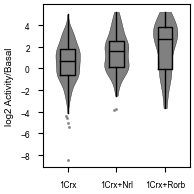

In [6]:
def annotate_motif_map(row):
    total = (row > 0.5).sum()
    if (0.5 < row["CRX"]) & (row["CRX"] <= 1.5):
        if total == 1:
            return "1Crx"
        elif (row["NRL"] > 0.5) & (total == 2):
            return "1Crx+Nrl"
        elif (row["RORB"] > 0.5) & (total == 2):
            return "1Crx+Rorb"
        else:
            return np.nan
    else:
        return np.nan
    
motif_groupings = occupancy_df.apply(annotate_motif_map, axis=1)
grouper = genomic_df.groupby(motif_groupings)
display(grouper["expression_log2"].describe())
fig = plot_utils.violin_plot_groupby(
    grouper["expression_log2"],
    "log2 Activity/Basal",
    figax=plt.subplots(figsize=plot_utils.get_figsize(0.3, 1))
)
plot_utils.save_fig(fig, os.path.join(figures_dir, "genomicMotifCountVsActivity"))

Plot effect sizes of deleting all motifs for a TF in all strong enhancers.

,count,mean,std,min,25%,50%,75%,max
NRL,,,,,,,,
1,193.0,0.561051,1.402104,-2.048648,-0.405026,0.237047,1.364031,4.906369
2,25.0,1.588346,2.184684,-1.667366,0.070251,0.712830,2.860115,5.487795
3,1.0,5.757839,NaN,5.757839,5.757839,5.757839,5.757839,5.757839


,count,mean,std,min,25%,50%,75%,max
NDF1,,,,,,,,
1,161.0,1.062838,1.475681,-1.475266,-0.007214,0.750697,1.846743,7.334941
2,18.0,1.234835,1.860445,-0.984444,-0.198743,0.798138,2.441889,4.829658
3,1.0,4.112778,NaN,4.112778,4.112778,4.112778,4.112778,4.112778
4,1.0,3.667327,NaN,3.667327,3.667327,3.667327,3.667327,3.667327


,count,mean,std,min,25%,50%,75%,max
RORB,,,,,,,,
1,178.0,1.327986,1.605778,-1.208525,0.007905,1.199401,2.169512,7.189979
2,9.0,3.209444,1.417348,1.139778,2.207923,3.241544,3.756999,5.959512
3,2.0,3.337911,0.651169,2.877465,3.107688,3.337911,3.568134,3.798357


,count,mean,std,min,25%,50%,75%,max
MAZ,,,,,,,,
1,120.0,0.001277,1.039642,-1.542228,-0.707125,-0.167822,0.273440,4.407896
2,31.0,-0.055251,1.403702,-1.551121,-0.973700,-0.513679,0.400248,4.247960
3,6.0,0.667527,1.139135,-0.558955,-0.077859,0.425772,1.147727,2.569930
4,2.0,1.760247,1.165511,0.936106,1.348176,1.760247,2.172317,2.584387
7,1.0,1.157593,NaN,1.157593,1.157593,1.157593,1.157593,1.157593


,count,mean,std,min,25%,50%,75%,max
MEF2D,,,,,,,,
1,25.0,1.064459,1.656841,-0.996574,-0.168162,0.716796,2.366690,5.550993
2,1.0,2.674496,NaN,2.674496,2.674496,2.674496,2.674496,2.674496


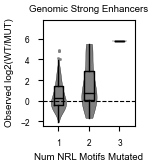

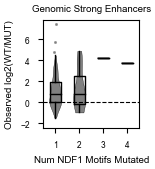

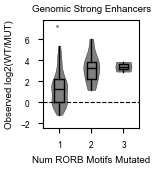

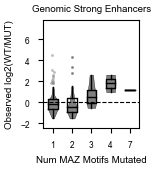

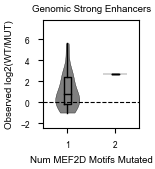

In [7]:
wt_df = activity_df[activity_df["original_genomic"]].set_index("label")
motif_deletion_df = activity_df[
    activity_df["rational_mutagenesis"] & activity_df["library"].str.contains("4|5")
]
# Parse out the designed deletion
designed_dels = motif_deletion_df["label"].str.split("HAND_").str[1]
# For each sequence, count the number of motifs mutated
deletion_counts = pd.DataFrame({
    tf: designed_dels.str.count(tf) for tf in tf_names
})
# Ignore cases when more than one type of motif was deleted
single_deletion_counts = deletion_counts[
    deletion_counts.max(axis=1) == deletion_counts.sum(axis=1)
]

single_deletion_df = motif_deletion_df.loc[single_deletion_counts.index]
# For each TF, calculate effect size of motifs relative to WT
for tf in ["NRL", "NDF1", "RORB", "MAZ", "MEF2D"]:
    tf_mut_df = single_deletion_df[single_deletion_counts[tf] > 0]
    mut_activity = tf_mut_df.set_index("immediate_precursor")["expression_log2"]
    wt_activity = wt_df.loc[mut_activity.index, "expression_log2"]
    effect_sizes = wt_activity - mut_activity
    # Group by number of motifs deleted
    grouper = effect_sizes.groupby(
        single_deletion_counts.loc[single_deletion_counts[tf] > 0, tf].values
    )
    display(grouper.describe().rename_axis(index=tf))
    fig = plot_utils.violin_plot_groupby(
        grouper,
        "Observed log2(WT/MUT)",
        figax=plt.subplots(figsize=plot_utils.get_figsize(0.22, 1))
    )
    ax = fig.axes[0]
    ax.set_xlabel(f"Num {tf} Motifs Mutated")
    ax.set_title("Genomic Strong Enhancers")
    # print(ax.get_ylim())
    ax.axhline(0, color="k", linestyle="--")
    ax.set_ylim((-2.4389725920684824, 7.775451125876526))
    
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"strongEnhancerMutate{tf}"))
